In [2]:
# Clear Jupyter notebook output and clear all variables
from IPython.display import clear_output
clear_output(wait=True)

# Remove all user-defined variables
for name in dir():
    if not name.startswith('_'):
        del globals()[name]
# Set path to the parent directory
import sys
import os
file = "/home/ashwin/GIT/PulsarAnalyticsKit/"
sys.path.append(file)

# Import necessary modules
from core.pulsar_analysis import pulsar_analysis
from core.generic_plotting import *


In [12]:
class pulsar_analysis(pulsar_analysis):
    def template(self):
        print("Template for pulsar analysis")

    def load_data(self):
        
        if self.data_type == 'ascii':
            #also skip first few lines
            self.raw_data = np.loadtxt(self.file_path, skiprows=self.skip_rows)
            self.n_channels = self.raw_data.shape[1]

        elif self.data_type == 'binary_int32':
            self.raw_data = np.fromfile(self.file_path, dtype=np.int32).reshape(-1, self.n_channels)
        
        elif self.data_type == 'binary_int16':
            self.raw_data = np.fromfile(self.file_path, dtype=np.int16).reshape(-1, self.n_channels)

        elif self.data_type == 'swan':
            dt = np.dtype([
                ('header', 'S8'), ('Source', 'S10'),
                ('Attenuator_1', '>u1'), ('Attenuator_2', '>u1'),
                ('Attenuator_3', '>u1'), ('Attenuator_4', '>u1'),
                ('LO', '>u2'), ('FPGA', '>u2'),
                ('GPS', '>u2'), ('Packet', '>u4'),
                ('data', '>i1', 1024)
            ])
            self.memmap_file = np.memmap(self.file_path, dtype=dt, mode='r')
            self.data_blocks = self.memmap_file['data']

            reshaped = self.data_blocks.reshape(-1)
            ch0 = (reshaped[0::2].astype(np.int32))
            ch1 = (reshaped[1::2].astype(np.int32))
            self.raw_data = np.stack([ch0, ch1], axis=1)
            self.n_channels = 2
        else:
            raise ValueError("Unsupported data type. Use 'ascii', 'binary_int32' or 'swan'.")        
        print(f"Given Data is of ndim : {self.raw_data.ndim} . shape : {self.raw_data.shape[1]}")
        self.n_channels = self.raw_data.shape[1]

In [18]:
crab_data = "/home/ashwin/GIT/PulsarAnalyticsKit/Data4Analysis/Crab/ch05_CRAB_20090725_095307_000.txt"
skip_rows = 1
pulsar = pulsar_analysis(crab_data, channel_names=["N", "S"], data_type='ascii',block_size=512, avg_blocks=60, sample_rate=33e6,skip_rows=skip_rows)


Given Data is of ndim : 2 . shape : 2
file_path: /home/ashwin/GIT/PulsarAnalyticsKit/Data4Analysis/Crab/ch05_CRAB_20090725_095307_000.txt
data_type: ascii
n_channels: 2
raw_data shape :  (33000448, 2)
channel_names: ['N', 'S']
block_size: 512
avg_blocks: 60
sample_rate: 33000000.0
intensity_matrix_ch_s shape :  (2,)
dedispersed_ch_s shape :  (2,)
dedispersed_choped_ch_s: [None None]
folded_ch_s: [None None]
center_freq_MHZ: 326.5
bandwidth_MHZ: 16.5
skip_rows: 1


In [21]:
crab_data = "/home/ashwin/GIT/PulsarAnalyticsKit/Data4Analysis/Crab/ch05_CRAB_20090725_095307_000_cut.mbr"
skip_rows = 1
pulsar = pulsar_analysis(crab_data, channel_names=["N", "S"], data_type='swan',block_size=512, avg_blocks=60, sample_rate=33e6,skip_rows=skip_rows)


Given Data is of ndim : 2 . shape : 2
file_path: /home/ashwin/GIT/PulsarAnalyticsKit/Data4Analysis/Crab/ch05_CRAB_20090725_095307_000_cut.mbr
data_type: swan
n_channels: 2
raw_data shape :  (33000448, 2)
channel_names: ['N', 'S']
block_size: 512
avg_blocks: 60
sample_rate: 33000000.0
intensity_matrix_ch_s shape :  (2,)
dedispersed_ch_s shape :  (2,)
dedispersed_choped_ch_s: [None None]
folded_ch_s: [None None]
center_freq_MHZ: 326.5
bandwidth_MHZ: 16.5
skip_rows: 1
memmap_file: [(b'MBRDSP05', b'CRAB', 30, 41, 32, 40, 280, 929, 35586, 26673630, [  1,  16,  17, ...,  -1,  -2,   5])
 (b'MBRDSP05', b'CRAB', 30, 41, 32, 40, 280, 929, 35586, 26673631, [ 20,   0,   3, ..., -13,   5,   5])
 (b'MBRDSP05', b'CRAB', 30, 41, 32, 40, 280, 929, 35586, 26673632, [  6,  26,  -3, ...,   6,   4,  17])
 ...
 (b'MBRDSP05', b'CRAB', 30, 41, 32, 40, 280, 929, 35587, 26738206, [  9,  -1,   1, ...,   3,   3,  13])
 (b'MBRDSP05', b'CRAB', 30, 41, 32, 40, 280, 929, 35587, 26738207, [ -7,  11,  -5, ...,   2,  19

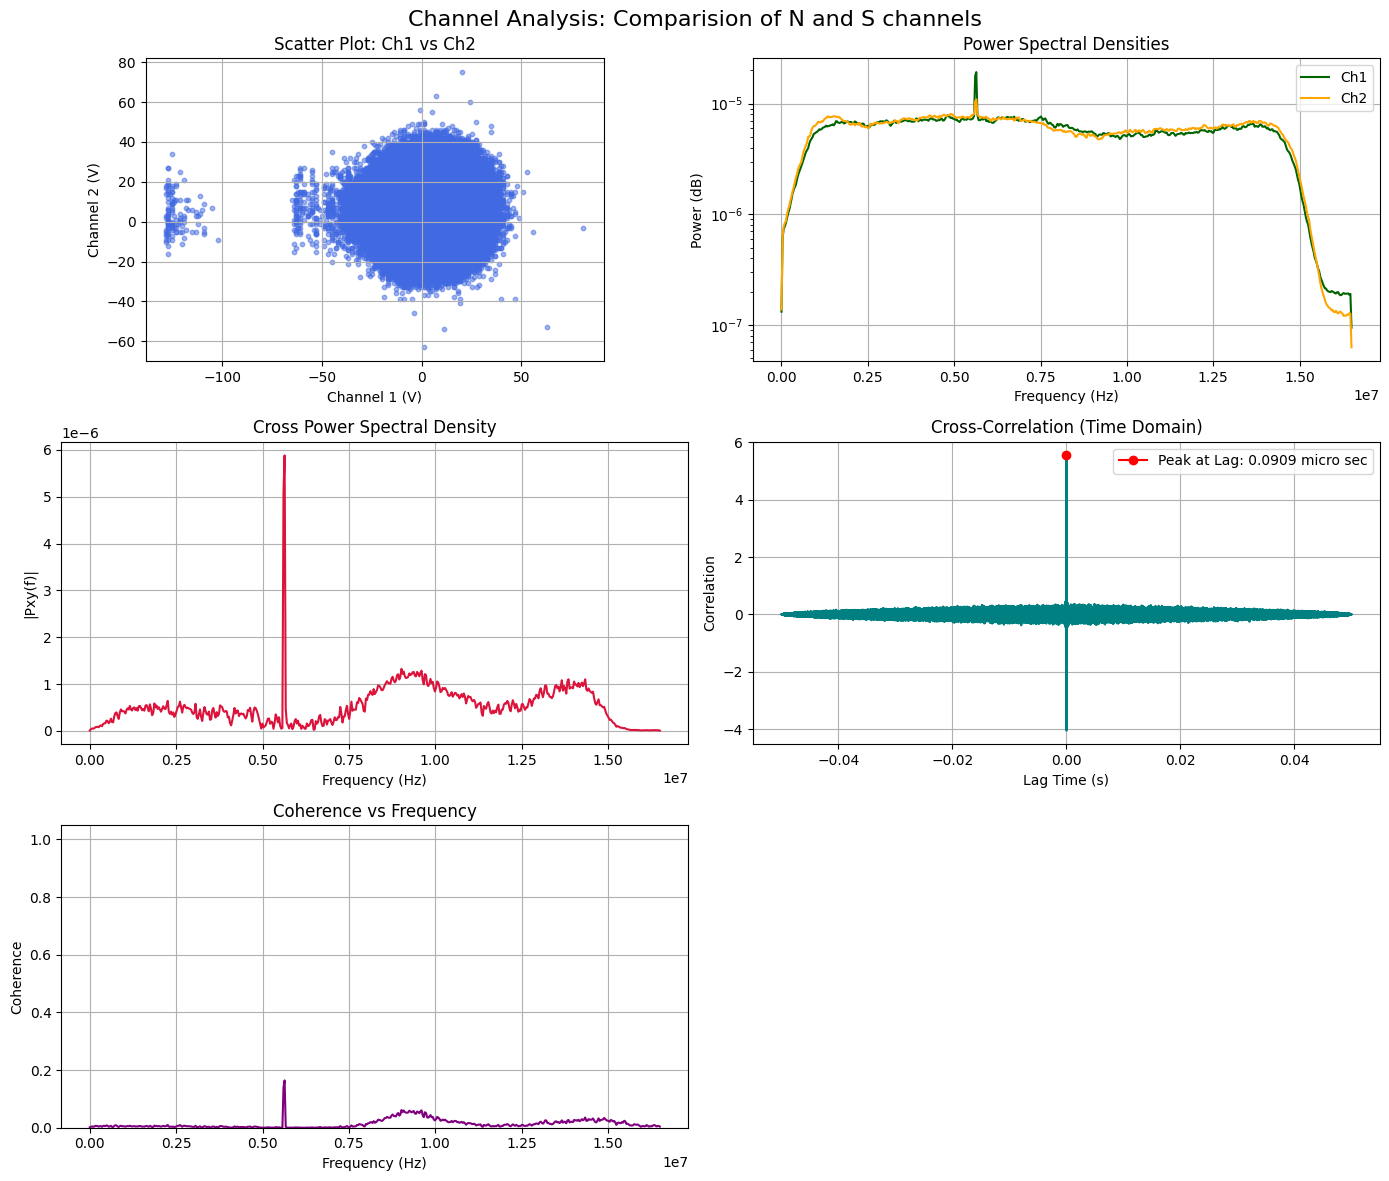

In [22]:
percentofData = 10 # Percentage of data to analyze
n = int(pulsar.raw_data.shape[0] * percentofData / 100)

ch0 = pulsar.raw_data[int(n/2):n , 0]
ch1 = pulsar.raw_data[int(n/2):n, 1]
fs = pulsar.sample_rate

compare_channels(ch0,ch1, fs, label="Comparision of N and S channels",)

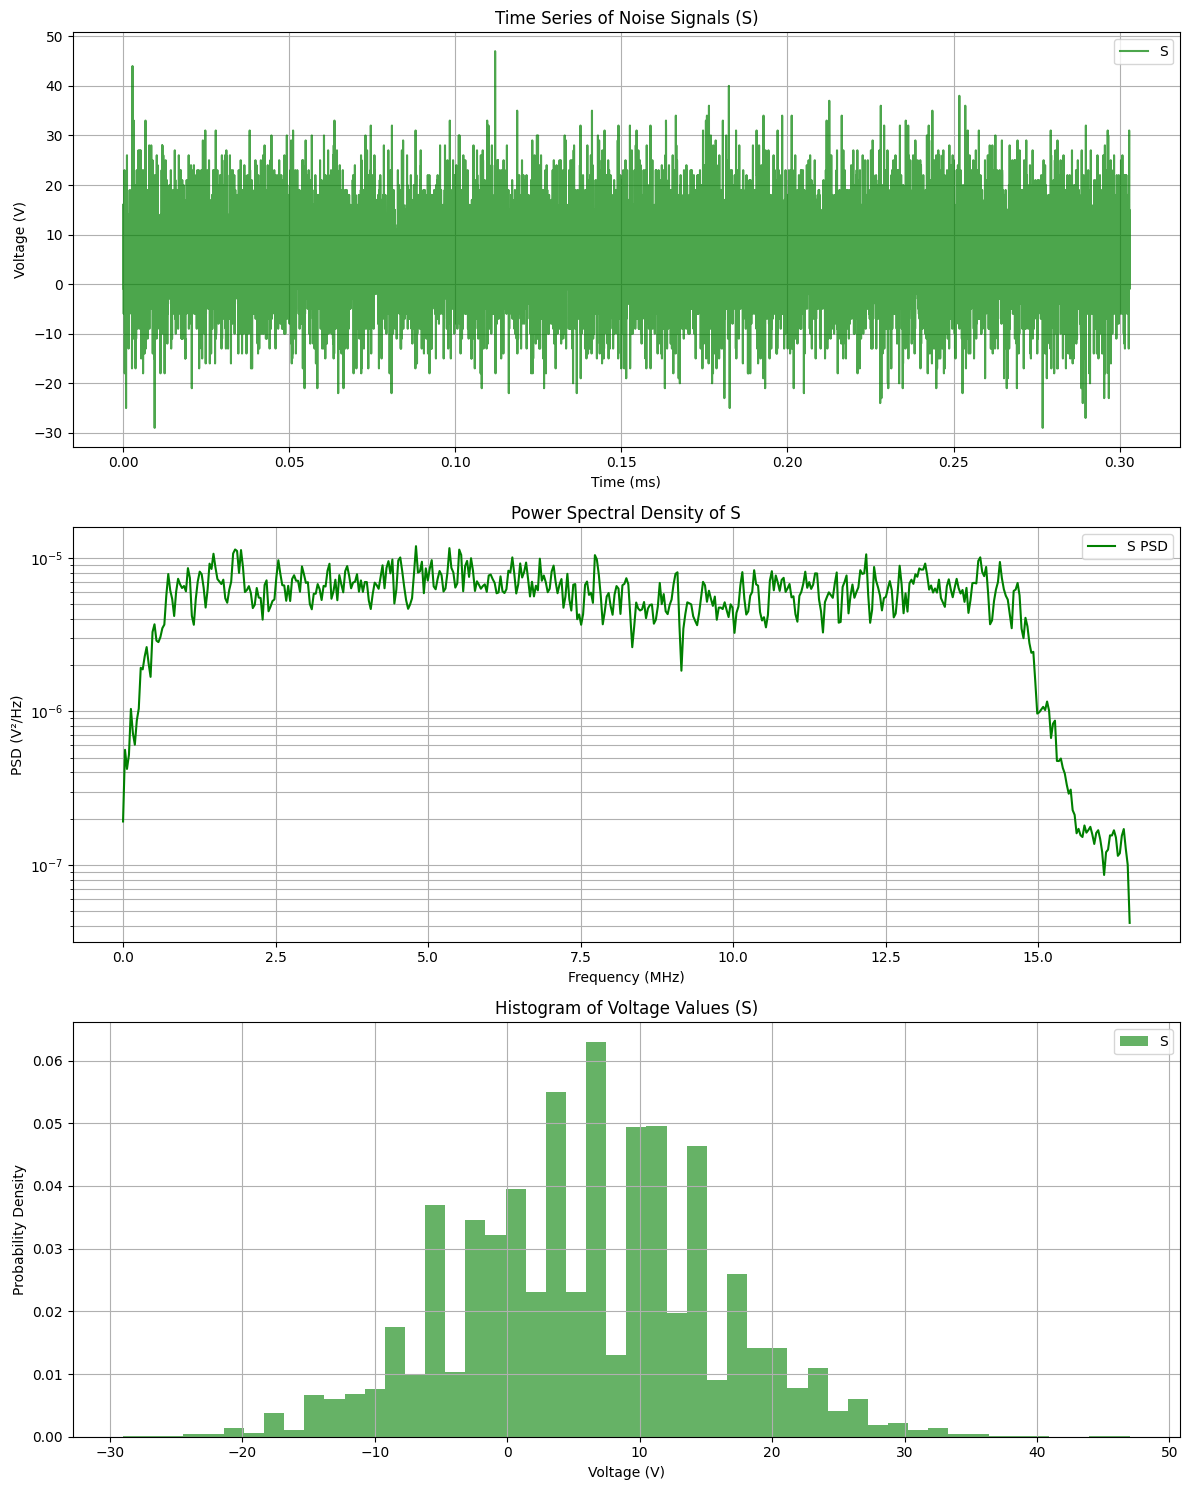

In [23]:
Plot_characterstics(pulsar,channel=1)

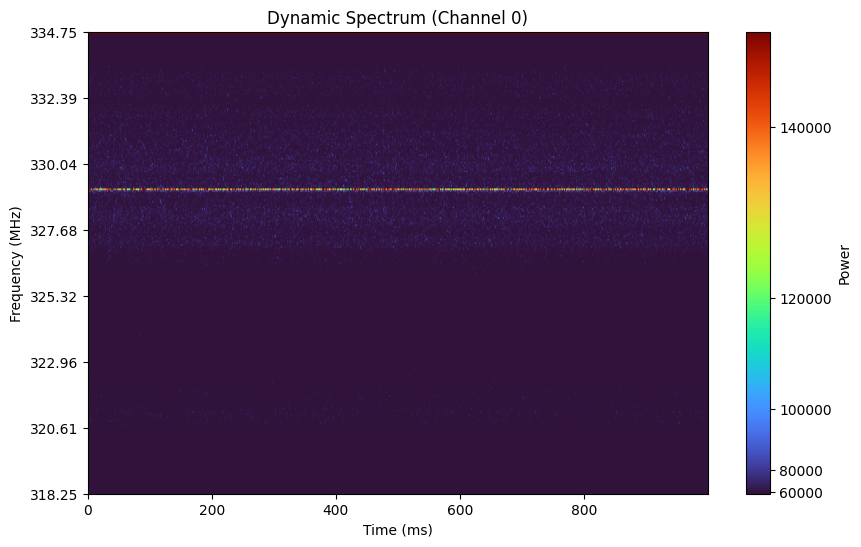

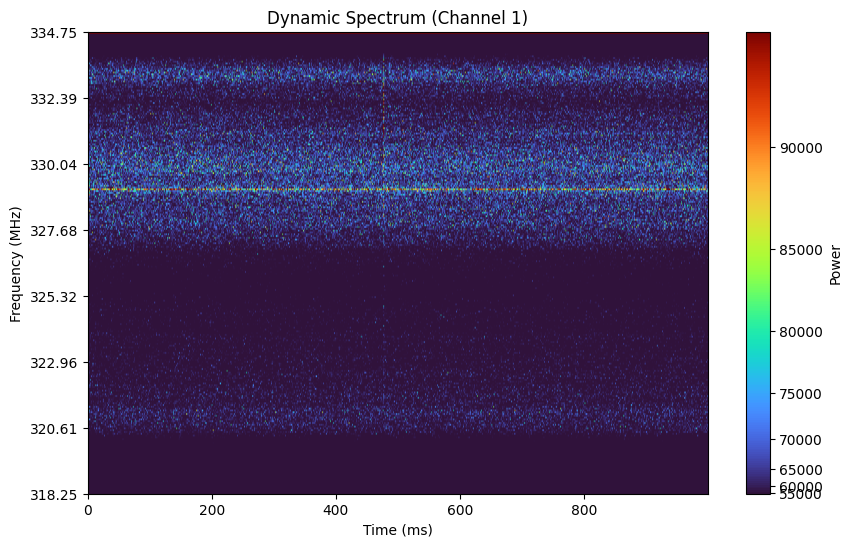

In [24]:
pulsar.compute_intensity_matrix()
plot_intensity_matrix(pulsar,channel = 0)
plot_intensity_matrix(pulsar,channel = 1)

In [25]:
import numpy as np

time_bin =  1/ pulsar.avg_blocks 

def channel_efficiency(matrix):
    """
    Compute efficiency for each frequency channel in the dynamic spectrum.

    Efficiency E = mean / (std * sqrt(TBP)) where TBP = number of time bins

    Args:
        matrix (2D numpy array): [time, frequency] intensity matrix

    Returns:
        1D numpy array of efficiencies for each frequency channel
    """
    n_time, n_freq = matrix.shape
    means = matrix.mean(axis=0)
    stds = matrix.std(axis=0)
    stds = np.where(stds == 0, 1, stds)  # Avoid division by zero

    TBP = n_time * time_bin
    efficiencies = means / (stds * np.sqrt(TBP))
    return efficiencies

def remove_rfi_by_efficiency(matrix, threshold=1 - 4 / np.sqrt(1024), fill_value=0, verbose=True):
    """
    Mask or replace RFI-affected frequency channels using efficiency threshold.

    Args:
        matrix (2D array): [time, frequency] intensity matrix
        threshold (float): Efficiency cutoff threshold (default = 1 - 4/√M where M=1024)
        fill_value: Value to replace RFI-affected channels with (e.g., np.nan or 0)
        verbose (bool): Whether to print removed channels info

    Returns:
        Cleaned 2D matrix
    """
    efficiency = channel_efficiency(matrix)
    bad_channels_up = efficiency < threshold
    bad_channels_down =efficiency > 0.5 + threshold
    bad_channels = np.logical_or(bad_channels_up, bad_channels_down)

    cleaned = matrix.copy()
    cleaned[:, bad_channels] = fill_value

    if verbose:
        print(f"Removed {np.sum(bad_channels)} RFI channels out of {matrix.shape[1]} using efficiency threshold {threshold:.4f}")
    return cleaned


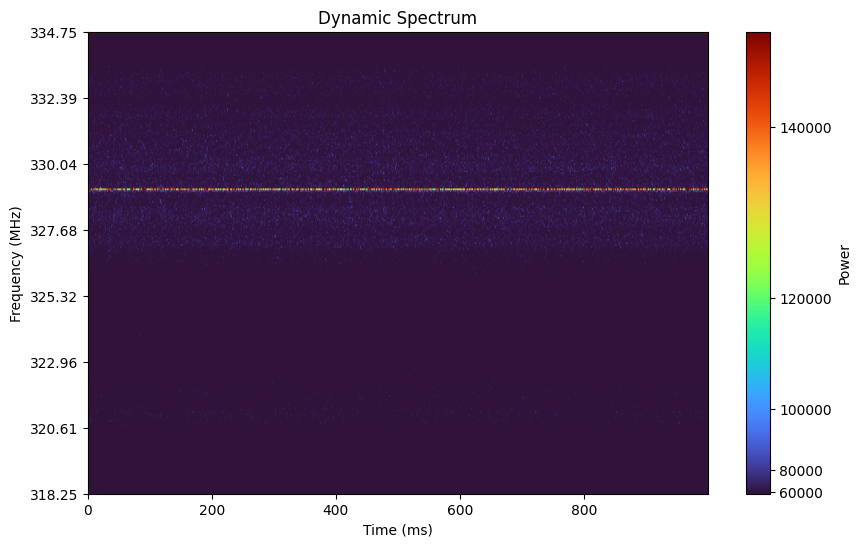

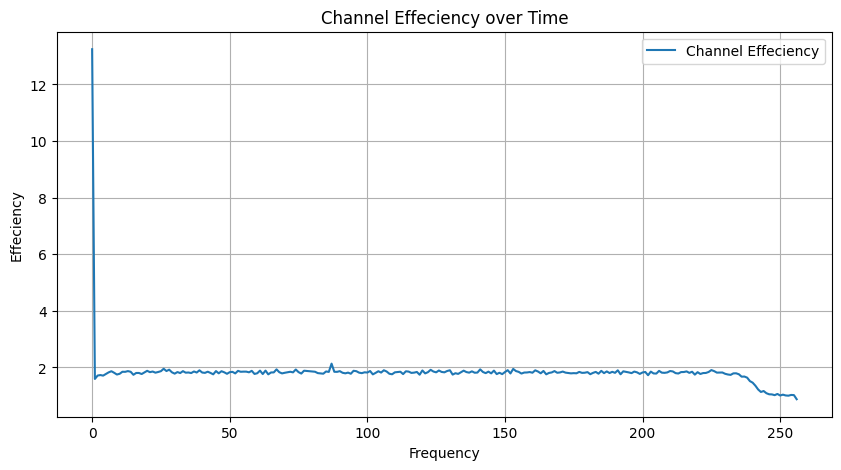

Removed 257 RFI channels out of 257 using efficiency threshold 0.1000


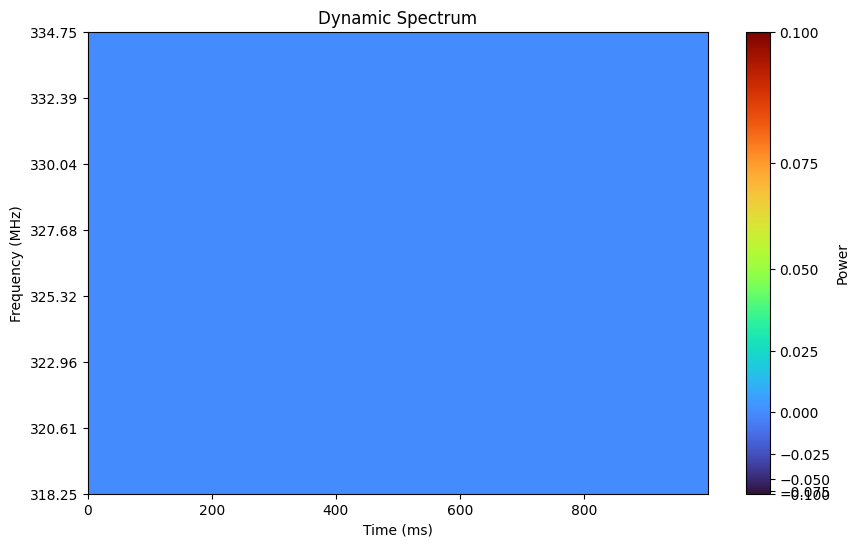

In [26]:
matrix = pulsar.intensity_matrix_ch_s[0]
plot_intensity_matrix_single(matrix, pulsar.block_size, pulsar.avg_blocks, pulsar.sample_rate, pulsar.bandwidth_MHZ, pulsar.center_freq_MHZ, gamma=2.5)

effeciency = channel_efficiency(matrix)

# Plot the effeciency
plt.figure(figsize=(10, 5))     
plt.plot(effeciency, label='Channel Effeciency')
plt.xlabel('Frequency')
plt.ylabel('Effeciency')
plt.title('Channel Effeciency over Time')
plt.legend()
plt.grid()
plt.show()

plot_intensity_matrix_single(remove_rfi_by_efficiency(matrix,threshold = 0.1), pulsar.block_size, pulsar.avg_blocks, pulsar.sample_rate, pulsar.bandwidth_MHZ, pulsar.center_freq_MHZ, gamma=2.5)



Flagging 2 channels as RFI heavy
Flagging 1 channels as RFI heavy


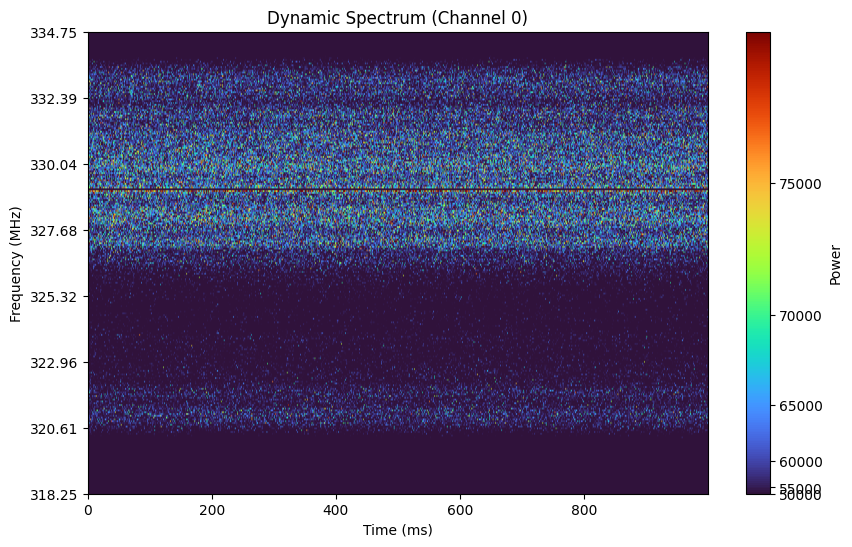

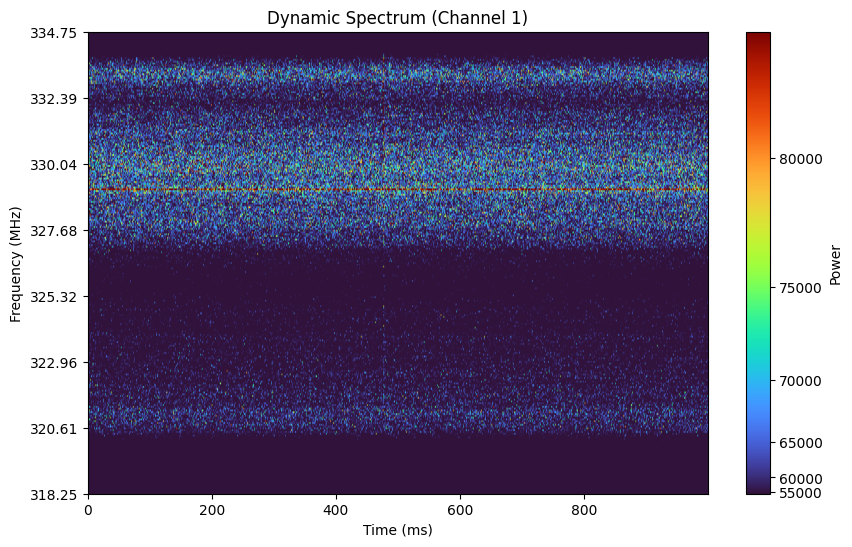

In [27]:
pulsar.compute_intensity_matrix()
pulsar.RFI_mitigation(freq_ch_std_threshold=0.5,freq_ch_mean_threshold=0.5,time_ch_threshold=7,fill_value=0)
plot_intensity_matrix(pulsar,channel = 0)
plot_intensity_matrix(pulsar,channel = 1)